In [26]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
import jax
from tqdm import tqdm
from h5py import File
from numpyro.infer import MCMC, NUTS, init_to_median, util
import corner
from copy import copy
from getdist import plots, MCSamples
import getdist

import csiborgtools

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [14]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00, 84.48it/s]


10:20:19: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 21608.99it/s]


10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 101/101 [00:02<00:00, 42.58it/s]


10:20:21: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 351.66it/s]


10:20:22: reading the catalogue.
10:20:22: reading the interpolated field.


100%|██████████| 20/20 [00:00<00:00, 123.83it/s]


10:20:22: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 1285.41it/s]


In [2]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [396]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "Carrick2015"
catalogue = "LOSS"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.06}

17:23:04: reading the catalogue.
17:23:04: reading the interpolated field.
17:23:04: calculating the radial velocity.


In [397]:
loader.los_density.shape

(50, 399)

### Maximizing the log-likelihood

In [398]:
# k = 0
# samples, stats, fmin, logz, bic = csiborgtools.flow.optimize_model_with_jackknife(loader, k, 10, True, get_model_kwargs=get_model_kwargs)

# print("Log Z: ")
# print(np.mean(logz), np.std(logz))

# print("BIC: ")
# print(np.mean(bic), np.std(bic))

# print("beta: ")
# print(*stats["beta"])
# print(samples["beta"])

#### Running HMC

In [399]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)

Selected 50/50 galaxies.


In [400]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=2500)

rng_key = jax.random.PRNGKey(5)

In [401]:
model_kwargs = {"sample_alpha": True}
mcmc.run(rng_key, **model_kwargs)

sample: 100%|██████████| 2750/2750 [00:32<00:00, 84.40it/s, 7 steps of size 4.13e-01. acc. prob=0.91]  


In [402]:
csiborgtools.numpyro_gof(model, mcmc, len(loader.cat), model_kwargs)

{'BIC': 773.5717163085938,
 'AIC': 754.4514770507812,
 'logZ': -356.15753173828125}

In [403]:
# Carrick+2015
# {'BIC': 782.9466552734375, 'AIC': 763.826416015625, 'logZ': -361.5248107910156}
# {'BIC': 782.5986328125, 'AIC': 765.3904418945312, 'logZ': -362.9004211425781}

# CSIBORG1
# {'BIC': 780.24365234375, 'AIC': 761.1234130859375, 'logZ': -352.1549987792969}

# CSiBORG2
# {'BIC': Array(757.9137, dtype=float32), 'AIC': Array(738.79346, dtype=float32), 'logZ': Array(-349.5533, dtype=float32)}

In [404]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
# potential_energy = mcmc.get_extra_fields()["potential_energy"]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          Vext_x    -16.69     75.95    -15.21   -132.91    118.30   1460.49      1.00
          Vext_y    -24.01    105.18    -28.09   -188.07    154.02   1522.27      1.00
          Vext_z    -88.49    152.80    -89.86   -341.05    169.93   1303.93      1.00
           alpha      1.01      0.39      0.95      0.40      1.61   2728.86      1.00
       alpha_cal      0.13      0.02      0.13      0.09      0.17   2106.27      1.00
            beta      0.44      0.11      0.45      0.28      0.62   2280.95      1.00
        beta_cal      3.53      0.19      3.53      3.21      3.83   1598.26      1.00
  e_mu_intrinsic      0.09      0.03      0.08      0.04      0.12   1790.78      1.00
         mag_cal    -18.19      0.04    -18.20    -18.26    -18.13   1351.76      1.00
         sigma_v    181.29     55.02    175.90     93.08    265.91   1889.45      1.00

Number of divergences: 0


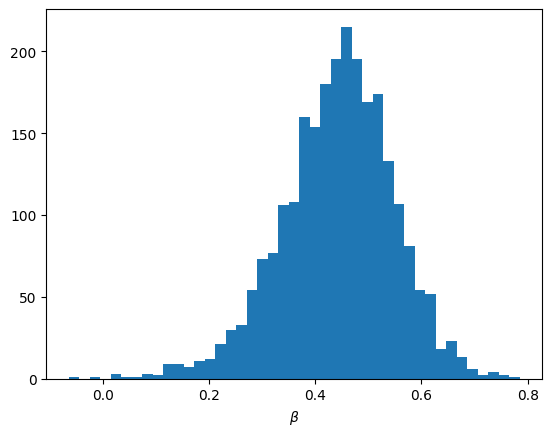

In [405]:
plt.figure()
plt.hist(samples["beta"], bins="auto")
plt.xlabel(r"$\beta$")
plt.show()

In [348]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

In [349]:
print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 204.55868530273438 +- 86.25765991210938
l    = 184.60682663258925 +- 61.737054807951814
b    = -19.484571487909193 +- 24.85469161630157
beta = 0.6694314479827881 +- 0.26649972796440125


In [352]:
if "alpha" in samples:
    data = np.vstack([samples["alpha"], samples["beta"], l, b, Vmag]).T
    labels = [r"$\alpha$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
else:
    data = np.vstack([samples["beta"], l, b, Vmag]).T
    labels = [r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

# keys = samples.keys()
# data = np.vstack([samples[key] for key in keys]).T
# labels = list(keys)


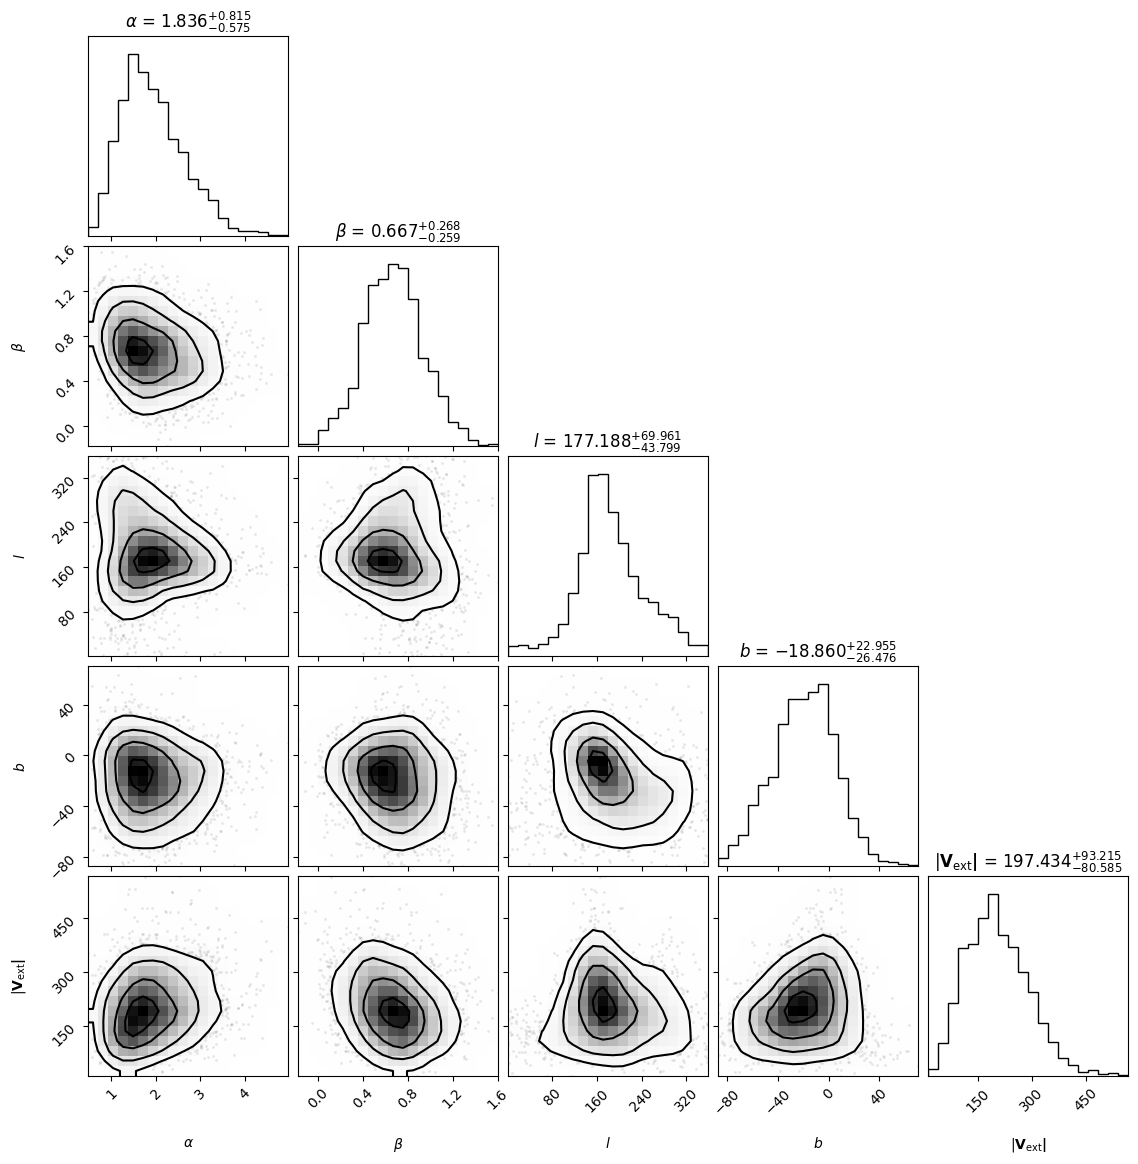

In [353]:
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)
fig.savefig(f"../plots/corner.png", dpi=300, bbox_inches="tight")

## Vizualize the results

####  Functions to read in the results

In [95]:
def read_samples(catalogue, simname, ksmooth, include_calibration=False):
    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    nsims = paths.get_ics(simname)

    Vx, Vy, Vz, beta, sigma_v, alpha = [], [], [], [], [], []
    BIC, AIC, logZ = [], [], []

    if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
        alpha_cal, beta_cal, mag_cal, e_mu_intrinsic = [], [], [], []
    else:
        raise ValueError(f"Catalogue {catalogue} not recognized.")

    fname = f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity/flow_samples_{catalogue}_{simname}_smooth_{ksmooth}.hdf5"
    with File(fname, 'r') as f:
        for __, nsim in enumerate(tqdm(nsims)):
            Vx.append(f[f"sim_{nsim}/Vext_x"][:])
            Vy.append(f[f"sim_{nsim}/Vext_y"][:])
            Vz.append(f[f"sim_{nsim}/Vext_z"][:])
            alpha.append(f[f"sim_{nsim}/alpha"][:])
            beta.append(f[f"sim_{nsim}/beta"][:])
            sigma_v.append(f[f"sim_{nsim}/sigma_v"][:])

            BIC.append(f[f"sim_{nsim}/BIC"][...])
            AIC.append(f[f"sim_{nsim}/AIC"][...])
            logZ.append(f[f"sim_{nsim}/logZ"][...])

            if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
                alpha_cal.append(f[f"sim_{nsim}/alpha_cal"][:])
                beta_cal.append(f[f"sim_{nsim}/beta_cal"][:])
                mag_cal.append(f[f"sim_{nsim}/mag_cal"][:])
                e_mu_intrinsic.append(f[f"sim_{nsim}/e_mu_intrinsic"][:])
            else:
                raise ValueError(f"Catalogue {catalogue} not recognized.")

    Vx, Vy, Vz, alpha, beta, sigma_v = np.hstack(Vx), np.hstack(Vy), np.hstack(Vz), np.hstack(alpha), np.hstack(beta), np.hstack(sigma_v)  # noqa

    gof = np.hstack(BIC), np.hstack(AIC), np.hstack(logZ)

    if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
        alpha_cal, beta_cal, mag_cal, e_mu_intrinsic = np.hstack(alpha_cal), np.hstack(beta_cal), np.hstack(mag_cal), np.hstack(e_mu_intrinsic)  # noqa
    else:
        raise ValueError(f"Catalogue {catalogue} not recognized.")

    # Calculate magnitude of V_ext
    Vmag = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    # Calculate direction in galactic coordinates of V_ext
    V = np.vstack([Vx, Vy, Vz]).T
    V = csiborgtools.cartesian_to_radec(V)
    l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

    if catalogue in ["LOSS", "Foundation", "Pantheon+"]:
        data = [alpha, beta, Vmag, l, b, sigma_v]
        names = ["alpha", "beta", "Vmag", "l", "b", "sigma_v"]

        if include_calibration:
            data += [alpha_cal, beta_cal, mag_cal, e_mu_intrinsic]
            names += ["alpha_cal", "beta_cal", "mag_cal", "e_mu_intrinsic"]
    else:
        raise ValueError(f"Catalogue {catalogue} not recognized.")

    return np.vstack(data).T, names, gof


def names_to_latex(names, for_corner=False):
    ltx = {"alpha": "\\alpha",
           "beta": "\\beta",
           "Vmag": "V_{\\rm ext} ~ [\\mathrm{km} / \\mathrm{s}]",
           "sigma_v": "\\sigma_v ~ [\\mathrm{km} / \\mathrm{s}]",
           }

    ltx_corner = {"alpha": r"$\alpha$",
                  "beta": r"$\beta$",
                  "Vmag": r"$V_{\rm ext}$",
                  "sigma_v": r"$\sigma_v$",
                  }

    labels = copy(names)
    for i, label in enumerate(names):
        if label in ltx:
            labels[i] = ltx_corner[label] if for_corner else ltx[label]

    return labels

### Quickview

100%|██████████| 1/1 [00:00<00:00, 69.24it/s]

BIC  = 773.225037 +- 0.000000
AIC  = 754.104797 +- 0.000000
logZ = -356.240234 +- 0.000000


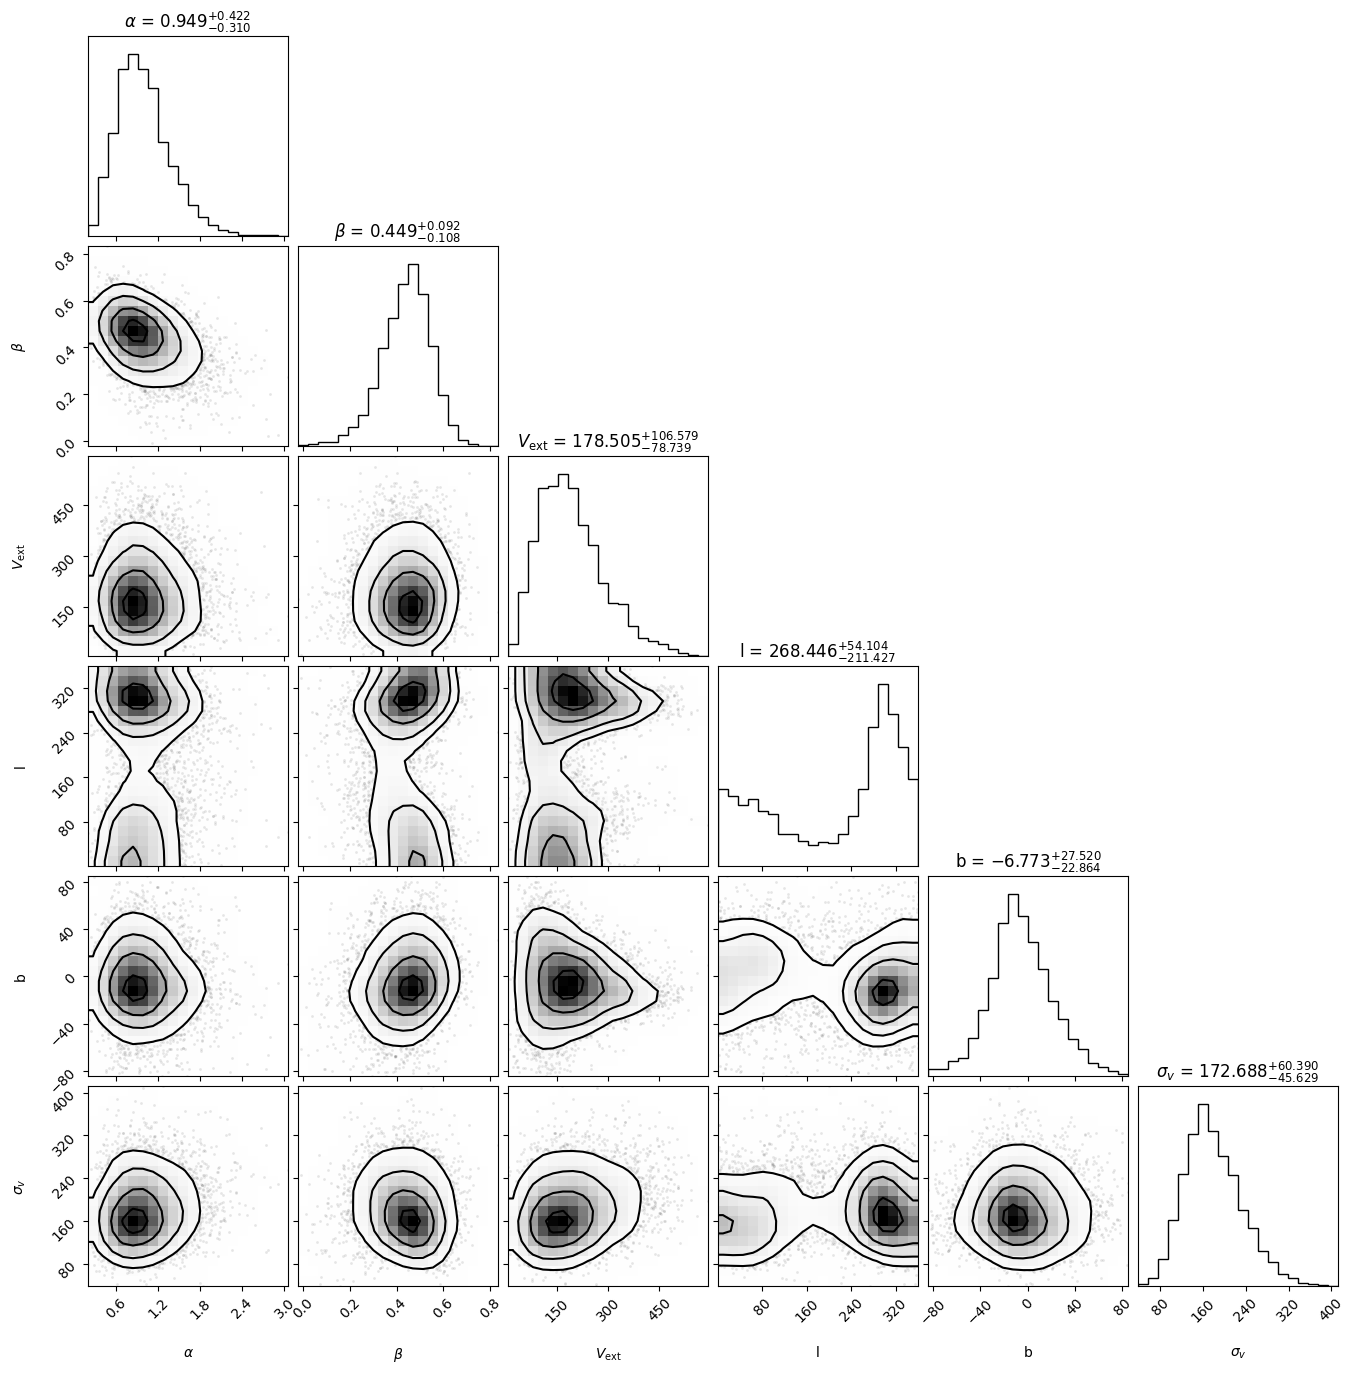

In [96]:
data, names, gof = read_samples("LOSS", "Carrick2015", 0)
print("BIC  = {:4f} +- {:4f}".format(np.mean(gof[0]), np.std(gof[0])))
print("AIC  = {:4f} +- {:4f}".format(np.mean(gof[1]), np.std(gof[1])))
print("logZ = {:4f} +- {:4f}".format(np.mean(gof[2]), np.std(gof[2])))

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS simulation comparison

In [89]:
data, names, gof = read_samples("LOSS", "Carrick2015", 0)
print("Carrick+2015, kappa = 0")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
LOSS_Carrick_0 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                           label=r"Carrick+2015, LOSS")

data, names, gof = read_samples("LOSS", "Carrick2015", 1)
print("Carrick+2015, kappa = 2")
print("BIC = {:.4f}".format(np.mean(gof[0])))
print("AIC = {:.4f}".format(np.mean(gof[1])))
print("logZ = {:.4f}".format(np.mean(gof[2])))
print()
LOSS_Carrick_1 = MCSamples(samples=data, names=names, labels=names_to_latex(names),
                           label=r"Carrick+2015, LOSS, $\kappa = 2$")

['AIC', 'BIC', 'Vext_x', 'Vext_y', 'Vext_z', 'alpha', 'alpha_cal', 'beta', 'beta_cal', 'e_mu_intrinsic', 'logZ', 'mag_cal', 'sigma_v']


100%|██████████| 1/1 [00:00<00:00, 131.62it/s]


Carrick+2015, kappa = 0
BIC = 773.2250
AIC = 754.1048
logZ = -356.2402

Removed no burn in
['AIC', 'BIC', 'Vext_x', 'Vext_y', 'Vext_z', 'alpha', 'alpha_cal', 'beta', 'beta_cal', 'e_mu_intrinsic', 'logZ', 'mag_cal', 'sigma_v']


100%|██████████| 1/1 [00:00<00:00, 126.38it/s]

Carrick+2015, kappa = 2
BIC = 775.7410
AIC = 756.6208
logZ = -357.0956

Removed no burn in


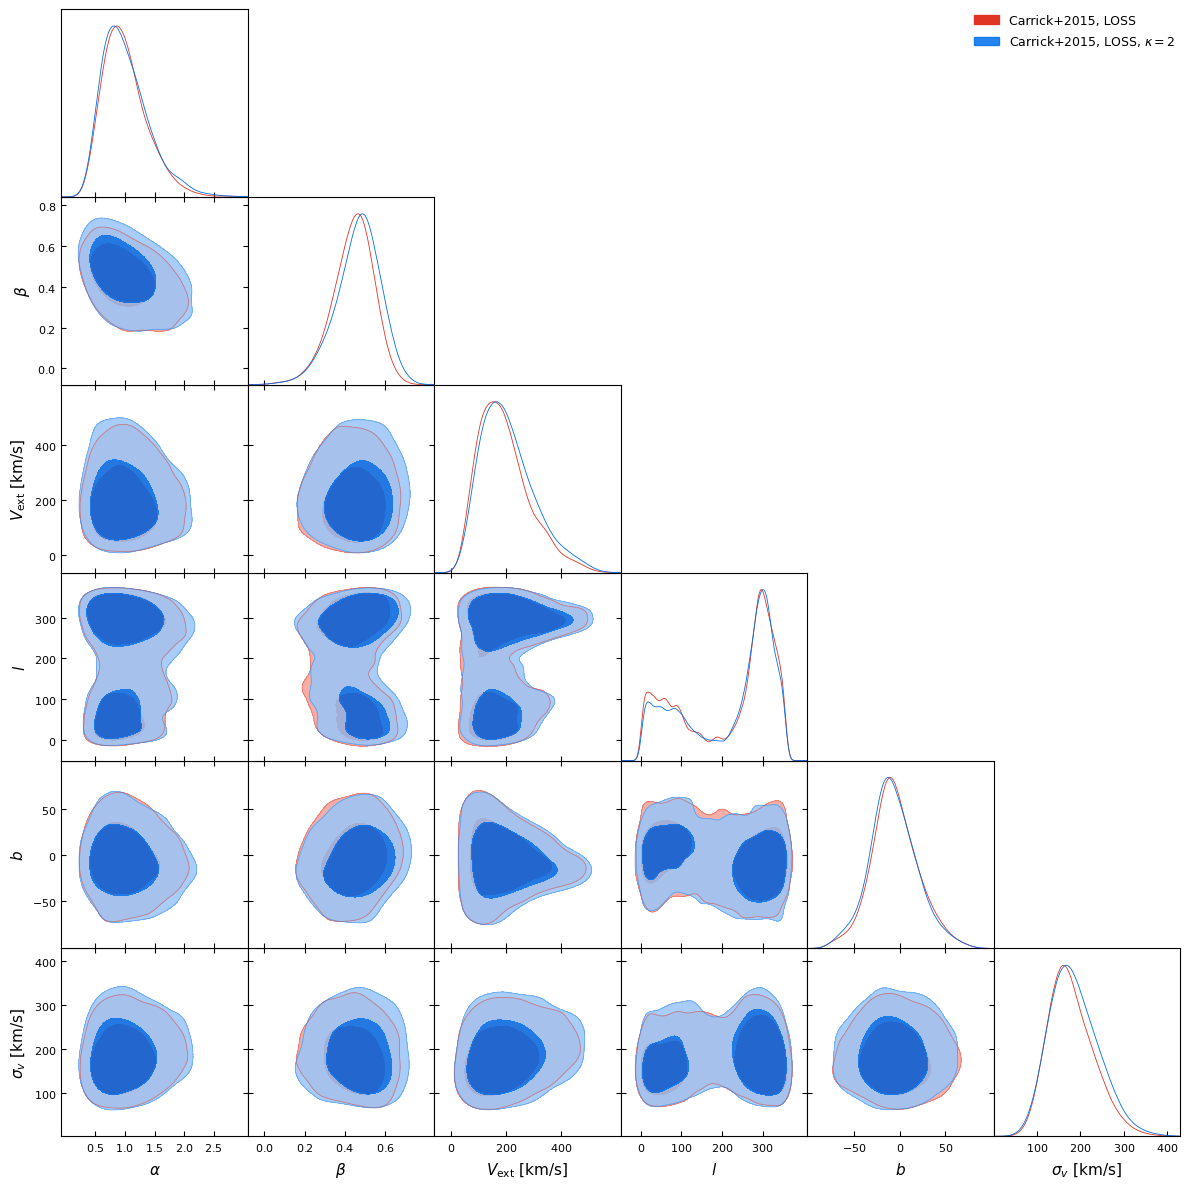

In [69]:
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
# g.settings.title_limit_fontsize = 14
g.triangle_plot([LOSS_Carrick_0, LOSS_Carrick_1], filled=True,
                legend_loc='upper right')
g.export(f"../plots/LOSS_Carrick2015_kappa_comparison.png", dpi=500,)


### Foundation comparison

In [299]:
0.906 * 0.43

0.38958

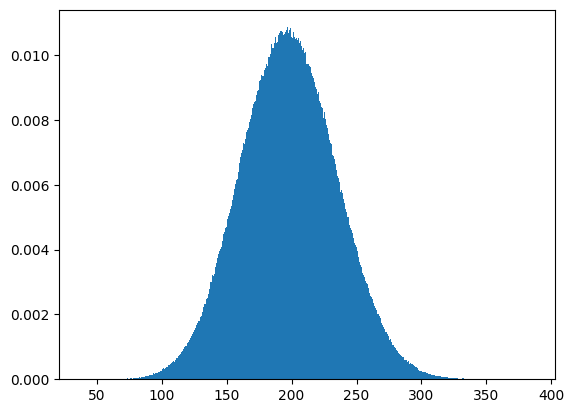

In [214]:
plt.figure()
plt.hist(V[:, 0], bins="auto", density=True)
plt.show()

In [219]:
print(beta.mean(), beta.std())
print(np.mean(V[:, 0]), np.std(V[:, 0]))
print(l.mean(), b.mean())

0.61461765 0.095553815
198.02641 36.928383
294.53874356626227 -5.542468825545464


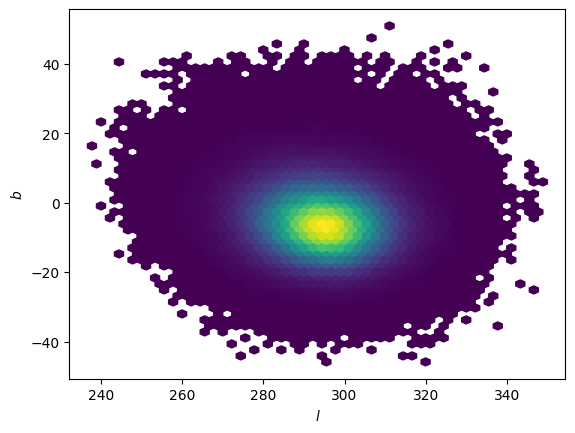

In [213]:
plt.figure()
plt.hexbin(l, b, gridsize=50, mincnt=1)
plt.xlabel(r"$l$")
plt.ylabel(r"$b$")
plt.show()

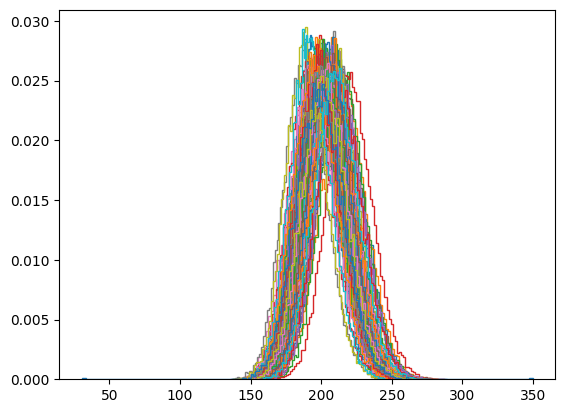

In [130]:
plt.figure()
for i in range(len(x)):
    plt.hist(x[i], bins="auto", density=True, histtype="step")

plt.show()

## Test bias

In [437]:
from jax.lax import cond

In [488]:


def bias(rho_norm, b):
    def bias_small(rho_norm, b):
        return jnp.log((1 + jnp.exp((1 - b + b * rho_norm))) / (1 + jnp.exp((1 - b))))

    def bias_large(rho_norm, b):
        return 1 - b + b * rho_norm - jnp.log(1 + jnp.exp(1 - b))

    return jnp.where(rho_norm < 3, 
                     bias_small(rho_norm, b), 
                     bias_large(rho_norm, b))

     

In [489]:
rho_norm = jnp.linspace(0, 100, 100)
b = 2
y = bias(rho_norm, b)

In [490]:
y

Array([  0.       ,   1.0148089,   2.7738497,   4.7473445,   6.767546 ,
         8.787747 ,  10.80795  ,  12.828152 ,  14.848353 ,  16.868557 ,
        18.888758 ,  20.90896  ,  22.929163 ,  24.949364 ,  26.969566 ,
        28.989767 ,  31.00997  ,  33.03017  ,  35.050373 ,  37.07057  ,
        39.090775 ,  41.110977 ,  43.13118  ,  45.151382 ,  47.171585 ,
        49.191784 ,  51.211987 ,  53.23219  ,  55.25239  ,  57.272594 ,
        59.292793 ,  61.312996 ,  63.3332   ,  65.3534   ,  67.373604 ,
        69.39381  ,  71.41401  ,  73.43421  ,  75.45441  ,  77.47461  ,
        79.49481  ,  81.515015 ,  83.53522  ,  85.55542  ,  87.57562  ,
        89.595825 ,  91.61603  ,  93.63623  ,  95.65643  ,  97.67663  ,
        99.69683  , 101.71703  , 103.737236 , 105.75744  , 107.77764  ,
       109.797844 , 111.81805  , 113.83825  , 115.85845  , 117.87865  ,
       119.89885  , 121.91905  , 123.939255 , 125.95946  , 127.97966  ,
       129.99986  , 132.02007  , 134.04027  , 136.06047  , 138.0

In [485]:
bias_small(rho_norm, b)

Array([ 0.       ,  1.0148089,  2.7738497,  4.753666 ,  6.768387 ,
        8.787859 , 10.807965 , 12.828154 , 14.848354 , 16.868557 ,
       18.888758 , 20.90896  , 22.929163 , 24.949364 , 26.969566 ,
       28.989767 , 31.00997  , 33.03017  , 35.050373 , 37.07057  ,
       39.090775 , 41.110977 , 43.13118  , 45.151382 , 47.171585 ,
       49.191784 , 51.211987 , 53.23219  , 55.25239  , 57.272594 ,
       59.292793 , 61.312996 , 63.3332   , 65.3534   , 67.373604 ,
       69.39381  , 71.41401  , 73.43421  , 75.45441  , 77.47461  ,
       79.49481  , 81.515015 , 83.53522  , 85.55542  , 87.57562  ,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        

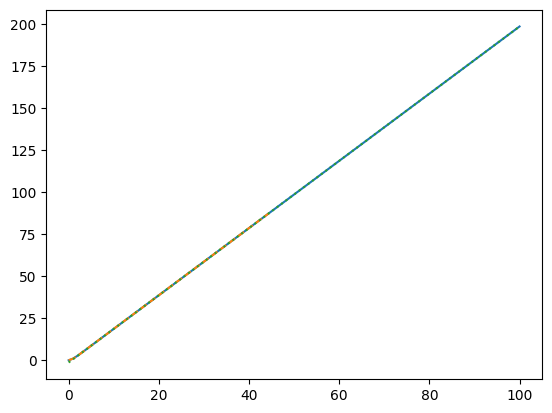

In [487]:
plt.figure()
plt.plot(rho_norm, y)
plt.plot(rho_norm, bias_small(rho_norm, b), ls="--")
plt.plot(rho_norm, bias_large(rho_norm, b), ls="dotted")
plt.show()

In [462]:
bias(loader._los_density[0], 2.)

Array([[1.3646735 , 1.434935  , 1.5887474 , 1.6949235 , 1.7769545 ,
        1.8709289 , 2.0290222 , 2.1513133 , 2.2334485 , 2.329708  ,
        2.444497  , 2.5160108 , 2.5457559 , 2.5692239 , 2.608365  ,
        2.6157517 , 2.5902514 , 2.5320826 , 2.4516525 , 2.3783646 ,
        2.3570633 , 2.2927842 , 2.235333  , 2.1849432 , 2.131144  ,
        2.1050715 , 2.1284485 , 2.1777897 , 2.2121887 , 2.2108288 ,
        2.2272425 , 2.2835732 , 2.2929268 , 2.2634182 , 2.241768  ,
        2.2274647 , 2.1347542 , 2.0022526 , 1.8764566 , 1.757152  ,
        1.5877327 , 1.4179734 , 1.2245289 , 1.0326    , 0.83725584,
        0.9779409 , 0.8560009 , 0.7459278 , 0.64249325, 0.5510863 ,
        0.4705007 , 0.40490875, 0.3523176 , 0.3036849 , 0.25979096,
        0.22670034, 0.2001784 , 0.17650758, 0.15544249, 0.1421564 ,
        0.1319982 , 0.12369715, 0.11719201, 0.11655279, 0.1178802 ,
        0.12243555, 0.12922992, 0.13944156, 0.15134403, 0.16509394,
        0.1822752 , 0.20241688, 0.22445495, 0.24

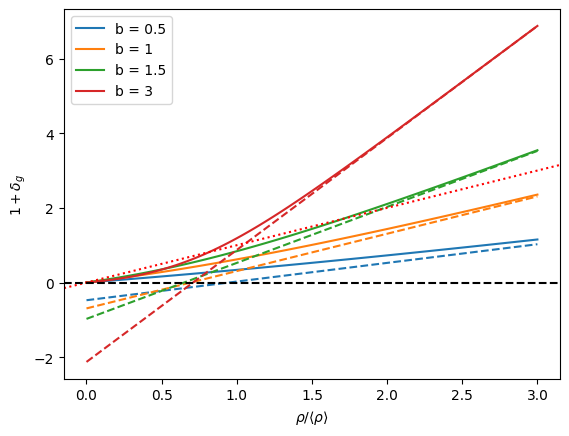

In [436]:
b = 1.4

rho = np.linspace(0, 3, 100)

def bias(rho, b):
    return np.log((1 + np.exp((1 - b + b * rho))) / (1 + np.exp((1 - b))))

def linear_bias(rho, b):
    return (1 - b + b * rho)

plt.figure()
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, b in enumerate([0.5, 1, 1.5, 3]):
    plt.plot(rho, bias(rho, b), label=f"b = {b}", c=cols[i])
    plt.plot(rho, 1 - b + b * rho - np.log(1 + np.exp(1 - b)), ls="--", c=cols[i])
    # plt.plot(rho, linear_bias(rho, b), ls="--", c=cols[i])
    

plt.axline((1, 1), slope=1, color="red", linestyle="dotted")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel(r"$\rho / \langle \rho \rangle$")
plt.ylabel(r"$1 + \delta_g$")
plt.legend()
plt.show()


In [133]:
 def get_field(kind):
    folder = "/mnt/extraspace/rstiskalek/catalogs"
    from os.path import join
    if kind == "density":
        fpath = join(folder, "twompp_density_carrick2015.npy")
        return np.load(fpath).astype(np.float32)
    elif kind == "velocity":
        fpath = join(folder, "twompp_velocity_carrick2015.npy")
        field = np.load(fpath).astype(np.float32)

        # Because the Carrick+2015 data is in the following form:
        # "The velocities are predicted peculiar velocities in the CMB
        # frame in Galactic Cartesian coordinates, generated from the
        # \(\delta_g^*\) field with \(\beta^* = 0.43\) and an external
        # dipole \(V_\mathrm{ext} = [89,-131,17]\) (Carrick et al Table 3)
        # has already been added.""
        field[0] -= 89
        field[1] -= -131
        field[2] -= 17
        field /= 0.43

        return field

In [135]:
density = get_field("density")
velocity = get_field("velocity")

In [136]:
from h5py import File

In [137]:
with File("/mnt/extraspace/rstiskalek/catalogs/Carrick2015_unscaled.hdf5", 'w') as f:
    f.create_dataset("density", data=density)
    f.create_dataset("velocity", data=velocity)
    